<a href="https://colab.research.google.com/github/LeeJaeEun0/st1226/blob/main/221226_ch04_ML_08_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM
* XGboost는 균등분할, LightGBM - 

* 장점
  * XGBoost보다 빠르고 높은 정확도를 보이는 경우

## LightGBM와 XGBOOST
* LightGBM
  * 한쪽으로 몰려도 모두 분류할 필요가 없다
  * 좌우 노드 수가 균등하지 않고, 가지가 깊게 펼쳐짐
  * 속도가 빠르게 학습 진행, 복잡성은 증가

* XGBoost
  * 뎁스를 늘림(반반으로 나눠서 늘려가는 형태)

* 데이터가 많으면 Light를 사용하지만 속도가 빠르다! 이지 더 좋은 결과를 가져온다는 것은 아님

## 이상거래 예측

## 인증 및 데이터 받기

In [1]:
# 캐글 제이슨 가져오는 방법

In [2]:
# 방법1
# 2. 강사의 kaggle.json (주기적 리셋)
!wget https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/kaggle.json 

--2022-12-26 04:59:09--  https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      65  --.-KB/s    in 0s      

2022-12-26 04:59:09 (2.79 MB/s) - ‘kaggle.json’ saved [65/65]



In [3]:
# https://www.kaggle.com/datasets/kartik2112/fraud-detection

# 1. 본인 kaggle 계정 인증 받음
# kaggle > Profile 이미지 > Account > Account > API > Create New API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"leejaeeun0","key":"a828382b9da56970fc5fc5b37a7759f7"}'}

In [4]:
# 인증 및 파일 다운로드 받기
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kartik2112/fraud-detection

fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!kaggle datasets list # kaggle에서 사용 가능한 데이터들

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          12832        370  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37            615         29  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           2660         70  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce Sales Data

## 압축 풀기 & 합치기

In [6]:
# zip -> unzip
# 파일 우측 클릭 > 경로 복사
# 파일 > fraudTest.csv, fraudTrain.csv 생성 확인 # 이미 파일이 있는경우 문제 생김
!unzip /content/fraud-detection.zip

Archive:  /content/fraud-detection.zip
replace fraudTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# ls 현재 경로에 있는 다른 파일/폴더를 불러오는 리눅스 명령어
!ls

 fraud-detection.zip  'gender_submission (1).csv'  'kaggle (3).json'
 fraudTest.csv	      'kaggle (1).json'		    sample_data
 fraudTrain.csv       'kaggle (2).json'


In [9]:
train = pd.read_csv('fraudTrain.csv', index_col=0) # 첫번째 열을 인덱스 컬럼으로 지정


In [10]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [11]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [12]:
train.tail()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0
1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.186110,0


In [13]:
test = pd.read_csv('fraudTest.csv', index_col=0)

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [15]:
# 열이 일치하는 두 데이터를 위아래로 합쳐준다 -> pd.concat([합쳐줄 df들])
df = pd.concat([train, test]) # 문제 있는 코드 - 인덱스 겹침 문제
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [16]:
df = pd.concat([train, test], ignore_index=True) # 인덱스 리셋
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [17]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

**Credit Card Transactions Fraud Detection Dataset**
* 이상 거래(fraud): 갑자기 해킹이나 전산 오류 등으로 인해 잘못된 금액 결제
* 카드 결제 데이터 셋 -> (...) -> is_faud(예측값, 종속변수)

## 이상거래 예측
* trans_date_trans_time : 거래 시간(날짜로 표시된 시간)
* cc_num : 카드 번호. 고윳값이기 때문에 여기서는 id처럼 활용할 수 있음 - 동명이인도 다른 값을 가짐
* merchant : 거래 상점
* category : 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
* amt: 거래금액 (amount)
* first / last : 이름
* gender : 성별
* city / street / state / zip : 고객 거주지 정보
* lat / long : 고객주소에 대한 위도 및 경도
* city_pop : 고객의 zipcode(우편번호) 속하는 인구 수
* job : 직업
* dob : 생년월일
* trans_num : 거래번호
* unix_time : 거래시간 (유닉스 타임스탬프 - 전산상으로 변환된 시간)
* merch_lat / merch_long : 상점의 위경도
---
* is_fraud : 사기거래 여부 (이상거래 여부) -> 종속변수

In [18]:
df.info() # not_null count가 안나오고 있음(데이터가 많아서)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [19]:
df.info(show_counts=True)# null(결측치)가 없는 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [20]:
pd.options.display.float_format= "{:.2f}".format
df.describe() # int, float 수치형 데이터 관련 통계 데이터 표시
# amt: 거래금액 (amount)
# city_pop : 고객의 zipcode 속하는 인구 수
# -> 선형 모델 어려움, 거리 기반 어렵겠다...

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00
mean,417386038393710400.00,70.06,48813.26,38.54,-90.23,88643.67,1358674218.83,38.54,-90.23,0.01
std,1309115265318734848.00,159.25,26881.85,5.07,13.75,301487.62,18195081.39,5.11,13.76,0.07
min,60416207185.00,1.00,1257.00,20.03,-165.67,23.00,1325376018.00,19.03,-166.67,0.00
25%,180042946491150.00,9.64,26237.00,34.67,-96.80,741.00,1343016823.75,34.74,-96.90,0.00
50%,3521417320836166.00,47.45,48174.00,39.35,-87.48,2443.00,1357089331.00,39.37,-87.44,0.00
75%,4642255475285942.00,83.10,72042.00,41.94,-80.16,20328.00,1374581485.25,41.96,-80.25,0.00
max,4992346398065154048.00,28948.90,99921.00,66.69,-67.95,2906700.00,1388534374.00,67.51,-66.95,1.00


In [21]:
df.describe(include='O')

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394,1852394
unique,1819551,693,14,355,486,2,999,906,51,497,984,1852394
top,2019-04-22 16:02:01,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,444 Robert Mews,Birmingham,TX,Film/video editor,1977-03-23,0b242abb623afc578575680df30655b9
freq,4,6262,188029,38112,40940,1014749,4392,8040,135269,13898,8044,1


* trans_date_trans_time : 거래 시간
* merchant : 거래 상점
* category : 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
* first / last : 이름
* gender : 성별 (F/M)
* city / street / state / zip : 고객 거주지 정보
* job : 직업
* dob : 생년월일
* trans_num : 거래번호
* unix_time : 거래시간 (유닉스 타임스탬프)
* merch_lat / merch_long : 상점의 위경도

## 전처리

In [22]:
# 사용되지 않는 변수 제거
# df.drop(..., axis=1) -> 원본 안 바꿔주는 것
# 1. df = df.drop(..., axis=1)
# inplace=True -> 모든 df에 있는 메소드에서 존재하지 X
# 깊은 복사, 얕은 복사 문제 때문에 가능하면 새로운 사본을 
# 2. df.drop(..., axis=1, inplace=True)
# pd -> 판다스 자체에서 불러오는 것이기 때문에 inplace X
df.drop(['first', 'last', # 이름 -> 이름 조합을 만들어서 full name / cc_num 고객은 특정 가능
         'street', 'city', 'state', 'zip', # 주소 -> 위도경도(lat, long)
         'trans_num', 'unix_time', # 거래번호 / 유닉스타임 (중복) -> trans_date_trans_time
         'job', 'merchant' # 직업, 가게명
         ], axis=1, inplace=True)

In [23]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'gender', 'lat',
       'long', 'city_pop', 'dob', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

## trand_date_trans_time

In [24]:
# trans_date_trans_time  object => datetime 타입으로 바꿔줘야함
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   category               object 
 3   amt                    float64
 4   gender                 object 
 5   lat                    float64
 6   long                   float64
 7   city_pop               int64  
 8   dob                    object 
 9   merch_lat              float64
 10  merch_long             float64
 11  is_fraud               int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 169.6+ MB


In [25]:
# pd.to_datetime -> 문자열 형태의 날짜 데이터를, df 기반 포맷을 바꿔줌
df.trans_date_trans_time = pd.to_datetime(df.trans_date_trans_time) # object => datetime로 바뀜
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   lat                    float64       
 6   long                   float64       
 7   city_pop               int64         
 8   dob                    object        
 9   merch_lat              float64       
 10  merch_long             float64       
 11  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 169.6+ MB


## 피쳐 엔지니어링
* 이상거래: 원래 고객의 거래 패턴에서 벗어나는 거래

### 결제 금액
* 평균에서 벗어난다 -> 정규분포(z 점수)에서 얼마나 멀리 벗어나 있는지 
* 서로 다른 특정한 개인 특정하는 방법 -> cc_num: 카드번호 별로 묶어서 -> 결제 금액 평균으로
* 갑자기 너무 큰 금액이 결제 된다면 이상거래 

In [26]:
# (groupby로 묶어준 그룹/ 속성)agg: 특정한 그룹별로 통계값, 대표값 추출
# mean -> 통계값 / std -> 표준편차 : Z점수(x - 평균)/ 표준편차 -> 평균으로부터 얼마나 떨어져 있는지 표준화한 값
amt_info = df.groupby('cc_num').amt.agg(['mean','std'])
# index(행 인덱스 이름)로 각 cc_num -> reset index?
amt_info.head()
# 카드별로 평균 소비액(mean), 표준편차(std)

,mean,std
cc_num,,
60416207185,59.26,142.87
60422928733,65.48,92.04
60423098130,96.38,1000.69
60427851591,107.49,131.01
60487002085,64.10,153.21


In [27]:
# 두 개의 데이터프레임을 열 방향으로 합쳐줄 때 -> merge
# A.merge(B) ->A가 왼쪽, B가 오른쪽해서 두 df을 합쳐줌
# 같은 cc_num을 가진 거래 기록과 cc_num별 소비기록 평균 및 표준편차를 매칭
# 거래 기록수 > cc_num 많다. => 같은 cc_num을 가졌을 경우 같은 평균, 표준편차를 공유
df = df.merge(amt_info, left_on='cc_num', right_index=True, how='left')

In [28]:
df.columns # 'mean', 'std'

Index(['trans_date_trans_time', 'cc_num', 'category', 'amt', 'gender', 'lat',
       'long', 'city_pop', 'dob', 'merch_lat', 'merch_long', 'is_fraud',
       'mean', 'std'],
      dtype='object')

In [29]:
# amt (각 거래 기록별 소비량)
# mean (cc_num별 평균 소비 금액)
# std (cc_num별 소비 금액의 소비편차)
# https://losskatsu.github.io/statistics/mean-vairance/
# z점수 : 특정한 값ㄷ이 평균 기준으로 얼마나 멀리 떨어져있는지
df[['cc_num', 'amt', 'mean','std']].head()

,cc_num,amt,mean,std
0,2703186189652095,4.97,89.41,127.53
1,630423337322,107.23,56.08,159.20
2,38859492057661,220.11,69.92,116.69
3,3534093764340240,45.00,80.09,280.08
4,375534208663984,41.96,95.34,94.32


In [30]:
# z-score = (amt/mean) / std
# 벡터화 연산(행들을 열들간 연산)
df['amt_z_score'] = (df['amt']-df['mean']) / df['std']

In [31]:
df['amt_z_score'].head() # 특정한 amt값이 평균대비 얼마나 떨어져잇는지 (부호: 어느 방향)

0   -0.66
1    0.32
2    1.29
3   -0.13
4   -0.57
Name: amt_z_score, dtype: float64

In [32]:
# z-score 산출을 위해 쓰인 다른 열들 drop
df.drop(['mean', 'std'], axis=1, inplace=True)

### 범주별 결제금액
* cc_num -> 카드번호별 / category -> (상점의) 분류.카테고리.범주

In [33]:
# 2개 이상의 그룹으로 나눌 때는 df.groupby([열 이름들...])
category_info = df.groupby(['cc_num', 'category']).amt.agg(['mean', 'std']).reset_index()
category_info # cc_num, category별로 -> 평균값 (결제액), 표준편차

,cc_num,category,mean,std
0,60416207185,entertainment,51.84,65.49
1,60416207185,food_dining,26.74,46.38
2,60416207185,gas_transport,59.78,15.76
3,60416207185,grocery_net,52.15,17.69
4,60416207185,grocery_pos,101.56,21.89
...,...,...,...,...
13166,4992346398065154184,misc_pos,60.00,167.23
13167,4992346398065154184,personal_care,48.78,49.52
13168,4992346398065154184,shopping_net,86.28,217.05
13169,4992346398065154184,shopping_pos,64.21,169.24


In [34]:
# df와 category_info를 합쳐주겠다 -> cc_num과 category를 기준으로
# mean, std
df = df.merge(category_info, on=['cc_num','category'], how='left')

In [35]:
# cc_num, category / mean, std / amt => z-score
df[['cc_num', 'category', 'amt', 'mean', 'std']].head()

,cc_num,category,amt,mean,std
0,2703186189652095,misc_net,4.97,84.86,116.07
1,630423337322,grocery_pos,107.23,99.64,23.90
2,38859492057661,entertainment,220.11,46.65,60.39
3,3534093764340240,gas_transport,45.00,61.54,15.75
4,375534208663984,misc_pos,41.96,35.48,4.93


In [36]:
# 범주별 결제금액 z-score
df['cat_z_score'] = (df['amt'] - df['mean']) / df['std']

In [37]:
df['cat_z_score'].head() # 1.69 (95%), 2.58 (99%)

0   -0.69
1    0.32
2    2.87
3   -1.05
4    1.31
Name: cat_z_score, dtype: float64

In [38]:
# z-score 산출을 위해 쓰인 다른 열들 drop
df.drop(['mean', 'std'], axis=1, inplace=True)

## 위.경도

In [39]:
# 두 지점 간의 거리 (위경도)
# latitude(위도, lat), longitude(경도, long, lng)
# geopy.distance.distance((lat1, lng1), (lat2, lng2)) -> 거리

In [40]:
# coordinate(좌표) - 위,경도.
# -- 좌표 : (위도, 경도) - latitude : 북/남 | logitude : 동/서
# 1. 상점 위경도 (merchant)
# 2. 고객 위경도 (customer)
# zip -> 2개 이상의 리스트를 원소 순서대로 묶어주겠음
df['merch_coord'] = pd.Series(zip(df.merch_lat, df.merch_long))
df['cust_coord'] = pd.Series(zip(df['lat'], df['long']))

In [41]:
import geopy.distance # 거리 구하는 파이썬 라이브러리
#  df.apply(lambda x: geopy.distance.distance(x['merch_coord'], x['cust_coord']).km, axis=1)
def get_distance(row): 
    coord1 = row['merch_coord'] # [merch_lat, merch_long] / 상점 위경도
    coord2 = row['cust_coord'] # [lat, long] / 고객 위경도
    return geopy.distance.distance(coord1, coord2).km

In [42]:
df['distance'] = df.apply(get_distance, axis=1)

In [43]:
df['distance'].head()

0    78.77
1    30.22
2   108.10
3    95.69
4    77.70
Name: distance, dtype: float64

In [44]:
df2 = df.copy()

In [ ]:
# .km 를 못한경우
# 78.77km => 78.77 => 문자열 타입에서 float64로 변환
# df['distance'] = df['distance'].str.split(expand=True)[0].astype('float64')

In [45]:
# 거주 위치 - 결제 위치가 너무 차이난다
# z-점수
distance_info = df.groupby('cc_num').agg(['mean','std']).distance

In [46]:
distance_info

,mean,std
cc_num,,
60416207185,73.53,28.70
60422928733,78.99,29.30
60423098130,77.83,28.19
60427851591,75.71,28.98
60487002085,79.44,28.77
...,...,...
4958589671582726883,76.74,29.12
4973530368125489546,78.75,29.45
4980323467523543940,72.27,28.28


In [48]:
# 1.
# distance_info = distance_info.reset_index() # -> cc_num
# df = df.merge(distance_info, on='cc_num', how='left')
# 2.
df = df.merge(distance_info, left_on='cc_num', right_index=True, how='left')

In [49]:
# z_score : 평균을 0으로 뒀을 때 얼마나 떨어있는지를 표준화 (z점수, 표준정규분포)
df['distance_z_code'] =(df['distance']-df['mean'])/df['std']

In [50]:
df['distance_z_code'].head()

0    0.03
1   -1.48
2    1.16
3    0.82
4    0.06
Name: distance_z_code, dtype: float64

In [51]:
# 사용한 통계치 drop
df.drop(['mean', 'std'], axis=1, inplace=True)

In [52]:
df.isna().mean() # 결측치가 없음

trans_date_trans_time   0.00
cc_num                  0.00
category                0.00
amt                     0.00
gender                  0.00
lat                     0.00
long                    0.00
city_pop                0.00
dob                     0.00
merch_lat               0.00
merch_long              0.00
is_fraud                0.00
amt_z_score             0.00
cat_z_score             0.00
merch_coord             0.00
cust_coord              0.00
distance                0.00
distance_z_code         0.00
dtype: float64

### 생년월일 (dob) - 연령

In [53]:
df['dob']

0          1988-03-09
1          1978-06-21
2          1962-01-19
3          1967-01-12
4          1986-03-28
              ...    
1852389    1966-02-13
1852390    1999-12-27
1852391    1981-11-29
1852392    1965-12-15
1852393    1993-05-10
Name: dob, Length: 1852394, dtype: object

In [55]:
pd.to_datetime(df['dob'])

0         1988-03-09
1         1978-06-21
2         1962-01-19
3         1967-01-12
4         1986-03-28
             ...    
1852389   1966-02-13
1852390   1999-12-27
1852391   1981-11-29
1852392   1965-12-15
1852393   1993-05-10
Name: dob, Length: 1852394, dtype: datetime64[ns]

In [56]:
# year만 받고 싶다
# pd.to_datetime(df['dob']).year 불가
# dt 속성 : 특정 시리즈/df에서 dt의 메소드/속성을 사용할 수 있게함 (참고: str)
pd.to_datetime(df['dob']).dt.year

0          1988
1          1978
2          1962
3          1967
4          1986
           ... 
1852389    1966
1852390    1999
1852391    1981
1852392    1965
1852393    1993
Name: dob, Length: 1852394, dtype: int64

In [57]:
df['age'] = 2022 - pd.to_datetime(df['dob']).dt.year # 만 나이

In [58]:
df.age

0          34
1          44
2          60
3          55
4          36
           ..
1852389    56
1852390    23
1852391    41
1852392    57
1852393    29
Name: age, Length: 1852394, dtype: int64

## 범주형 변수 처리

In [59]:
# 필요 없는 열(변수) drop
df.drop(['cc_num','lat','long','merch_lat','merch_long','dob','merch_coord','cust_coord'], axis=1, inplace=True)

In [62]:
df.describe(include='O')

,category,gender
count,1852394,1852394
unique,14,2
top,gas_transport,F
freq,188029,1014749


In [63]:
# 더미 변수 만들기
df = pd.get_dummies(df,
                    columns = df.describe(include='O').columns,
                    drop_first=True)

In [64]:
df

,trans_date_trans_time,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_code,age,category_food_dining,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2019-01-01 00:00:18,4.97,3495,0,-0.66,-0.69,78.77,0.03,34,0,...,0,0,0,1,0,0,0,0,0,0
1,2019-01-01 00:00:44,107.23,149,0,0.32,0.32,30.22,-1.48,44,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 00:00:51,220.11,4154,0,1.29,2.87,108.10,1.16,60,0,...,0,0,0,0,0,0,0,0,0,1
3,2019-01-01 00:01:16,45.00,1939,0,-0.13,-1.05,95.69,0.82,55,0,...,0,0,0,0,0,0,0,0,0,1
4,2019-01-01 00:03:06,41.96,99,0,-0.57,1.31,77.70,0.06,36,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,43.77,519,0,-0.17,-0.05,77.03,0.05,56,0,...,1,0,0,0,0,0,0,0,0,1
1852390,2020-12-31 23:59:09,111.84,28739,0,0.36,1.16,100.02,0.69,23,0,...,0,0,1,0,0,0,0,0,0,1
1852391,2020-12-31 23:59:15,86.88,3684,0,-0.02,0.44,80.89,0.29,41,0,...,0,0,1,0,0,0,0,0,0,0
1852392,2020-12-31 23:59:24,7.99,129,0,-0.59,-0.01,53.06,-0.73,57,0,...,0,0,0,0,0,0,0,0,1,1


## 모델링

## 훈련셋/시험셋

In [65]:
# 과거의 이상거래를 사용해서 -> 미래의 이상거래를 감지
# 시간 단위로 훈련셋/시험셋을 나눠줘야함
# grid search cv, train_test_split
# 날짜 단위로 나누기

In [66]:
df.index # 정수 인덱스

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1852384, 1852385, 1852386, 1852387, 1852388, 1852389, 1852390,
            1852391, 1852392, 1852393],
           dtype='int64', length=1852394)

In [67]:
# trans_date_trans_time
df.set_index('trans_date_trans_time', inplace=True)

In [68]:
df.index # 2020-07-01 이전, 이후 데이터 나눠서 train_test

DatetimeIndex(['2019-01-01 00:00:18', '2019-01-01 00:00:44',
               '2019-01-01 00:00:51', '2019-01-01 00:01:16',
               '2019-01-01 00:03:06', '2019-01-01 00:04:08',
               '2019-01-01 00:04:42', '2019-01-01 00:05:08',
               '2019-01-01 00:05:18', '2019-01-01 00:06:01',
               ...
               '2020-12-31 23:57:18', '2020-12-31 23:57:50',
               '2020-12-31 23:57:56', '2020-12-31 23:58:04',
               '2020-12-31 23:58:34', '2020-12-31 23:59:07',
               '2020-12-31 23:59:09', '2020-12-31 23:59:15',
               '2020-12-31 23:59:24', '2020-12-31 23:59:34'],
              dtype='datetime64[ns]', name='trans_date_trans_time', length=1852394, freq=None)

In [69]:
train = df[df.index < '2020-07-01'] # 2020년 7월 1일 이전 데이터 (경계 미포함)
test = df[df.index >= '2020-07-01'] # 2020년 7월 1일 이후 데이터 (경계 포함)

In [70]:
# 예측값(종속변수, y) : is_fraud
# 관측값(독립변수, X) : 나머지
X_train = train.drop('is_fraud', axis=1)
y_train = train['is_fraud']
X_test = test.drop('is_fraud', axis=1)
y_test = test['is_fraud']

## 모델 학습

In [71]:
import lightgbm as lgb

In [72]:
# 연속형 변수를 예측하는 '회귀' 문제를 푼다면? lgb.LGBMRegressor
# 범주형 변수를 예측하는 '분류' 문제를 푼다면? lgb.LGBMClassifier
model = lgb.LGBMClassifier(random_state=26)

In [73]:
model.fit(X_train, y_train)

LGBMClassifier(random_state=26)

In [76]:
pred = model.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9965186688759485

In [78]:
1 - df.is_fraud.mean()

0.9947899852839083

## 평가

In [79]:
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score

In [81]:
# 실제 y값, 예측 y값을 넣어주면 confusion matrix를 그려주는 함수
def confusion_matrix_view(y_test, pred):
    cf_matrix = confusion_matrix(y_test, pred) # 배열 
    #  [ [ TN , FP ]
    #      FN , TP ]  ]
    print(cf_matrix)
    group_names = ['TN','FP','FN','TP'] # 각기 4개의 그룹으로
    # TN : 실제 0, 분류 0
    # TP : 실제 1, 분류 1
    # FP : 위양성, 실제 0, 분류 1 -> 1종 오류
    # FN : 위음성, 실제 1, 분류 0 -> 2종 오류
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()] # 그룹별 갯수 / arr.flatten() -> 한 줄로
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)] # 그룹별 비중, 비율
                        # flatten -> 2 x 2 -> 4 -> 합계로 나눠준 것
    # v1 : 그룹명 -> 이진분류(TN,FP,FN,TP...) -> 3개이상이면? 0->1, 1->1...
    # v2 : 그룹별 갯수
    # v3 : 그룹별 비중(비율)
    # \n -> Enter (줄바꿈)
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2) # 2 x 2
    # ['TN','FP','FN','TP']
    '''
      [['TN','FP'],
       ['FN','TP']]
    '''
    # seaborn.heatmap(열마다 크기에 따라서 색상/짙음 정도를 결정)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
    plt.ylabel('True') # 실제값
    plt.xlabel('Predicted') # 예측값
    plt.show()
    print(classification_report(y_test, pred))

[[522602   1047]
 [   783   1229]]


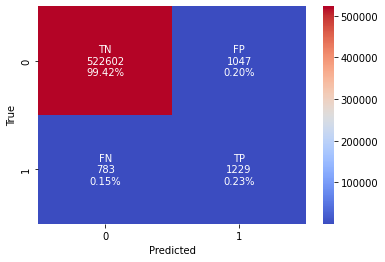

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.54      0.61      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.77      0.80      0.79    525661
weighted avg       1.00      1.00      1.00    525661



In [82]:
confusion_matrix_view(y_test, pred)
# FP - 1종오류
# FN - 2종오류

In [84]:
# 정밀도 - precision - 1종 오류(FP)
# 재현률 - recall - 2종 오류(FN)

# fl점수 - 정밀도와 재현율을 조화평균 -> 두 수치의 영향력을 모두 확인
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.54      0.61      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.77      0.80      0.79    525661
weighted avg       1.00      1.00      1.00    525661



In [85]:
# 0, 1 => 분류 되기 전에 얼마나 각각의 확률이 산출되는지
model.predict_proba(X_test)

array([[9.99875434e-01, 1.24566042e-04],
       [9.99877296e-01, 1.22704031e-04],
       [9.99869010e-01, 1.30989526e-04],
       ...,
       [9.99868033e-01, 1.31966775e-04],
       [9.99337678e-01, 6.62322460e-04],
       [9.99834092e-01, 1.65908474e-04]])

In [87]:
# 각 행 => 입력받은 시험셋의 행 데이터 별로 각각의 분류가 될 확률
# 2차원 행렬 -> 각각 열
# 1열 : 0에 대한 예측 값(확률값)
# 2열: 1에 대한 예측값(확률값)
proba = model.predict_proba(X_test)
proba

array([[9.99875434e-01, 1.24566042e-04],
       [9.99877296e-01, 1.22704031e-04],
       [9.99869010e-01, 1.30989526e-04],
       ...,
       [9.99868033e-01, 1.31966775e-04],
       [9.99337678e-01, 6.62322460e-04],
       [9.99834092e-01, 1.65908474e-04]])

In [88]:
# numpy 인덱싱 -> [행, 열] -> [: 모든행, n]
proba[:,1] # 예측값이 1이 될 확률, 이상거래일 확률

array([0.00012457, 0.0001227 , 0.00013099, ..., 0.00013197, 0.00066232,
       0.00016591])

In [89]:
proba = proba[:,1] # proba = 이상거래일 확률 예측치

In [91]:
# default : 0.5보다 크면 ->1로 부준
# 민감하게 혹은 둔감하게 처리가능
#case1 : 0.2만 넘으면 1로 분류(느슨한)
#case2 : 0.8만 넘으면 1로 분류(엄격한)
# 벡터화 연산으로 비교 연산 (> 0.2) => T/F => astype(int) 0/1
probar_int1 = (proba > 0.2).astype('int')

In [92]:
pred.mean() # 기준이 0.5일 때의 예측치

0.004329786687618065

0과 1로 구성되어 있는 데이터에 `mean` 평균을 내면 -> 1의 비중을 알 수 있음 ->예측치로 환산한다면? => 이상거래로 분류된 비율

In [93]:
pred.mean()# 기준이 0.5일 때의 예측치

0.004329786687618065

In [94]:
probar_int1.mean()# 기준이 0.2일 때의 예측치

0.006190301353914405

In [95]:
proba_int2 = (proba > 0.8).astype('int')
proba_int2

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
proba_int2.mean() # 기준이 0.8일 때의 예

0.002733700997410879

[[522602   1047]
 [   783   1229]]


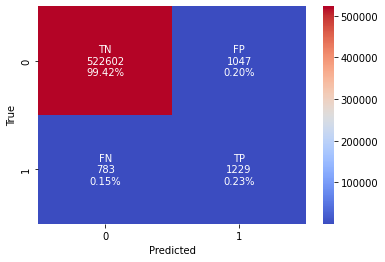

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.54      0.61      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.77      0.80      0.79    525661
weighted avg       1.00      1.00      1.00    525661



In [98]:
# 0.5 를 기준으로 했을 때의 혼동행렬, 분류리포트
confusion_matrix_view(y_test, pred)

[[521834   1815]
 [   573   1439]]


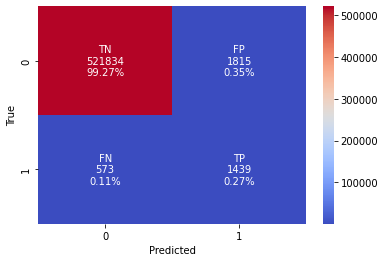

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.44      0.72      0.55      2012

    accuracy                           1.00    525661
   macro avg       0.72      0.86      0.77    525661
weighted avg       1.00      1.00      1.00    525661



In [102]:
# 0.2 를 기준으로 했을 때의 혼동행렬, 분류리포트
confusion_matrix_view(y_test,probar_int1)
# FP가 늘었음 (1종 오류가 늘었음 -> 이상거래가 아닌데 맞다고 판단한 것이 늘었음)
# FN은 줄었음 (2종 오류가 줄엇음 -> 이상거래 맞는데 아니라고 판단한 것이 줄었음)

[[523093    556]
 [  1131    881]]


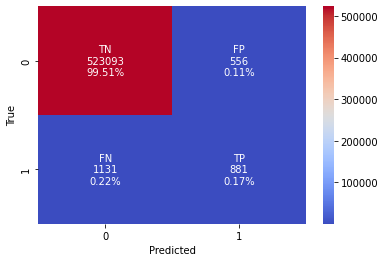

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.61      0.44      0.51      2012

    accuracy                           1.00    525661
   macro avg       0.81      0.72      0.75    525661
weighted avg       1.00      1.00      1.00    525661



In [104]:
# 0.8 를 기준으로 했을 때의 혼동행렬, 분류리포트
confusion_matrix_view(y_test, proba_int2)
# FP가 줄었음 (1종 오류가 줄었음 -> 이상거래가 아닌데 맞다고 판단한 것이 줄었음)
# FN은 늘었음 (2종 오류가 늘었음 -> 이상거래 맞는데 아니라고 판단한 것이 늘었음)

## ROC 곡선 & AUC

* 이진분류 모델을 평가하는 방법
* 기준점에 영향을 받지 않으므로 여러 모델을 비교할 때 요긴하게 사용

* [참고](https://losskatsu.github.io/machine-learning/stat-roc-curve/#2-%EB%AF%BC%EA%B0%90%EB%8F%84%EC%99%80-%ED%8A%B9%EC%9D%B4%EB%8F%84)
* 이진분류 모델을 평가하는 방법으로 기준점에 영향을 받지 않기 때문에 여러 모델을 비교할 때 요긴하게 사용
* AUC는 ROC 곡선의 아래 면적을 의미
    * 0.5~1 사이의 값을 지니며 높을수록 좋은 모델
## ROC 곡선
> 민감도, 특이도 개념을 활용
### 민감도 (TPR)
$TPR = \frac{TP(참 양성)}{TP(참 양성) + FN(거짓 음성)}$
* 재현율과 수식이 같음
* 실제 1인 것 중 얼마만큼 제대로(1로) 예측되었는지
* 1에 가까울 수록 좋은 수치
### 특이도 (TNR) **
$TNR = \frac{TN(참 음성)}{FP(거짓 양성) + TN(참 음성)}$
* 실제 0인 것 중 얼마만큼 제대로(0로) 예측되었는지
* 1에 가까울 수록 좋은 수치
$FPR = \frac{FP(거짓 양성)}{FP(거짓 양성) + TN(참 음성)}$
* 실제 0인 것 중 얼마만큼 잘못(1로) 예측되었는지
* 0에 가까울 수록 좋은 수치
$FPR = 1 - TNR$

민감도(TPR)을 높이기 위해서 기준을 낮추면, 반대로 FPR은 증갛게 되어 있음(역의 관계)
하지만 예측력이 좋은 모델이라면 그 변화치가 높지 않음

![ROC](https://i.imgur.com/euCumVh.png)
* 기준점을 바꿨을 때 TPR, FPR이 어떻게 바뀌는지 보여주는 그래프
* 최악의 경우 (학습이 전혀 안될 경우) -> 빨간색 점선
### AUC (Area Under the ROC Curve)
* ROC 곡선의 아래쪽에 해당하는 면적
* 0.5~1 사이의 값을 가지며 커질 수록 더 좋은 분류기라는 의미
![AUC](https://i.imgur.com/udlCMW4.png)

In [105]:
# 0과 1을 얼마나 잘 분류하는지 (성능 좋은지)
# proba -> 1이 될 확률
roc_auc_score(y_test, proba)

0.9614512689355635

## 하이퍼 패러미터 튜닝
* 그리드 서치 : 주입할 패러미터 목록들을 딕셔너리 형태로 넣어서, 각각의 패러미터들을 모두 조합한 모델들을 학습 시켜봐서, 최적의 모델을 찾는 것
  * 너무 많이 시도 해봤자, 결국은 시간낭비 일 수 있음
  * 빨리 적당한 패러미터 조합이 필요할 수도 있음
* 랜덤 서치: 더 넒은 영역의 하이퍼 파라미터 값을 더 짧은 시간에 다양하게 활용
  * 일부만 추출해서 모델링 -> 시간이 더 짧아짐

## 랜덤 서치

In [106]:
from sklearn.model_selection import RandomizedSearchCV

In [107]:
# 랜덤 서치에 사용될 파라미터들 (딕셔너리)
params = {
    "n_esimators": [100, 500, 1000], # 총 생성할 트리 개수
    "learning_rate": [0.01, 0.05, 0.1, 0.3], # 경사하강법에 적응할 학습률(오차를 어느 범위만큼 수정할까)
    # 너무 작으면 오버피팅, 시간오래걸림
    # 너무 크면 학습이 제대로 안됨
    "lambda_l1": [0, 10, 20, 30, 50],
    "lambda_l2": [0, 10, 20, 30, 50],
    # 경사하강법과 관련 -> 오버피팅 줄이기
    "max_depth": [5, 10, 15, 20], # 트리의 최대 깊이, 과적합
    "subsmaple": [0.6, 0.8, 1] # 일부 데이터만 사용해서 트리를 만들게(1: 전체)
}

## L1 정규화(lambda_l1)와 L2 정규화(lambda_l2)
* 라쏘 회귀(lasso regression) - L1 정규화
* 릿지 회귀(rigde regression) - L2 정규화
> 둘 다 매개 변수에 패널티를 가해서 그 영향력(계수)을 감소 시키는 방법.<br>
오버피팅을 방지하는 목적으로 쓰임

In [110]:
model2 = lgb.LGBMClassifier(random_state=25)
# (학습에 쓰일 모델, param_distributions 랜덤 서치에 쓰일 파라미터들, n_iter 몇 번 조합을 추출할지
#  scoring 모델 간 비교 수치)
rs = RandomizedSearchCV(model2, param_distributions=params, n_iter=30, scoring='roc_auc', random_state=26, n_jobs=-1)

In [111]:
import time
start = time.time()
rs.fit(X_train, y_train)
print(time.time() - start)

1596.212590456009


In [112]:
rs.best_params_ # 이 조합을 쓰면 됨

{'subsmaple': 1,
 'n_esimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'lambda_l2': 50,
 'lambda_l1': 0}

In [113]:
rs.best_score_

0.9946987574978194

In [116]:
rs_proba = rs.predict_proba(X_test)

In [118]:
# rs_proba[:, 1]: proba -> 0열 : 0이 될 확률, 1열: 1이 될 확률
# [모든 행 중에, 1번째 열] -> 1이 될 확률 호출
roc_auc_score(y_test, rs_proba[:, 1])

0.990716523281437

[[522460   1189]
 [   481   1531]]


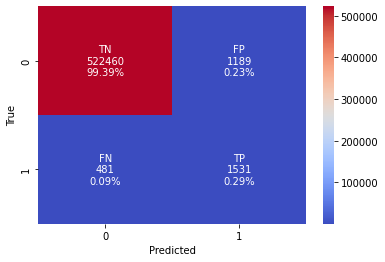

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.56      0.76      0.65      2012

    accuracy                           1.00    525661
   macro avg       0.78      0.88      0.82    525661
weighted avg       1.00      1.00      1.00    525661



In [122]:
# 0.2로 조금 더 느슨하게(정밀도를 희생하고, 재현율을 높임)
rs_proba_int1 = (rs_proba[:,1] > 0.2).astype('int') # 1이 될 확률이 0.2만 넘어가도 1로 취급
confusion_matrix_view(y_test, rs_proba_int1)

[[523604     45]
 [  1175    837]]


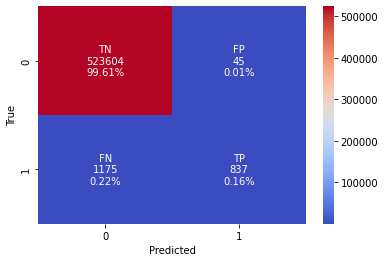

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.95      0.42      0.58      2012

    accuracy                           1.00    525661
   macro avg       0.97      0.71      0.79    525661
weighted avg       1.00      1.00      1.00    525661



In [121]:
# 0.2로 조금 더 느슨하게(정밀도를 높이고, 재현율을 희생)
rs_proba_int2 = (rs_proba[:,1] > 0.8).astype('int') # 1이 될 확률이 0.8이 넘어가야 1로 취급
confusion_matrix_view(y_test, rs_proba_int2) # 정밀도가 높아진 이상해진 경우

## model.train() 함수

In [123]:
#model.fit(X_train, y_train) -> 학습
# model.train(...) <- 원래 함수 <= 사용하기 편하게 수정 fit
# 훈련셋, 시험셋(검증셋)

||train|fit|
|-|-|-|
|검증셋|모델링 - 검증셋|검증 X|
|데이터셋|데이터프레임->별도포맷변환|데이터프레임,시리즈|
|하이퍼패러미터|하이퍼패러미터 Default X|기본값|
|사이킷런 연동|X|O(그리드 서치...)|

* 학습 -> 학습셋 => model => 시험셋
학습 -> 학습셋과는 별개로 (검증셋) => model


In [124]:
# 훈련셋 / 시험셋 (fit)
# 훈련셋 / 검증셋 / 시험셋 (train) - 3개로 분리됨
train = df[df.index < '2020-01-01']
val = df[(df.index >= '2020-01-01') & (df.index < '2020-07-01')] # validation
test = df[df.index >= '2020-07-01']

In [125]:
def get_X_y(df):
  X = df.drop('is_fraud', axis=1)
  y = df.is_fraud
  return(X,y)

In [126]:
# 훈련셋, 검증셋, 시험셋(X,y)
X_train, y_train = get_X_y(train)
x_val, y_val = get_X_y(val)
X_test, y_test = get_X_y(test)

In [128]:
# 데이터셋 변환
d_train = lgb.Dataset(X_train, label=y_train)
d_val =lgb.Dataset(x_val, label=y_val)


In [129]:
param_set = rs.best_params_
param_set

{'subsmaple': 1,
 'n_esimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'lambda_l2': 50,
 'lambda_l1': 0}

In [130]:
# 평가 관련 수치
param_set['metrics'] = 'auc'
param_set

{'subsmaple': 1,
 'n_esimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'lambda_l2': 50,
 'lambda_l1': 0,
 'metrics': 'auc'}

In [131]:
# model.train(모델링할 때 쓰이는 하이퍼 파라미터 값들, 훈련셋, valid_sets=[검증셋],
#             early_stopping_rounds: 최대 학습시간 제한하고, 더 이상 score가 개선 안되면 멈추기
#             verbose_eval : n번째에서 메시지 표시)
# param_set['metrics'] = 'auc' -> 100
# verbose_eval=100 : 100번마다 알림을 주세요
model_train = lgb.train(param_set, d_train, valid_sets=[d_val],
                        early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.990771
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.991794


In [133]:
pred_train = model_train.predict(X_test)

In [134]:
pred_train # 확률값으려 결과가 나옴

array([0.0002194 , 0.00037097, 0.00034467, ..., 0.0002976 , 0.00148323,
       0.00024512])

[[523328    321]
 [   844   1168]]


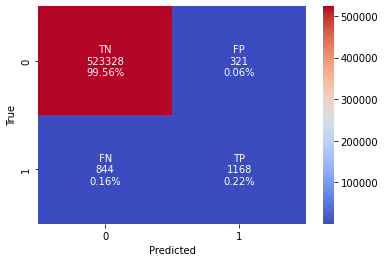

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.78      0.58      0.67      2012

    accuracy                           1.00    525661
   macro avg       0.89      0.79      0.83    525661
weighted avg       1.00      1.00      1.00    525661



In [135]:
confusion_matrix_view(y_test, (pred_train > 0.5).astype('int'))

## 변수 중요도

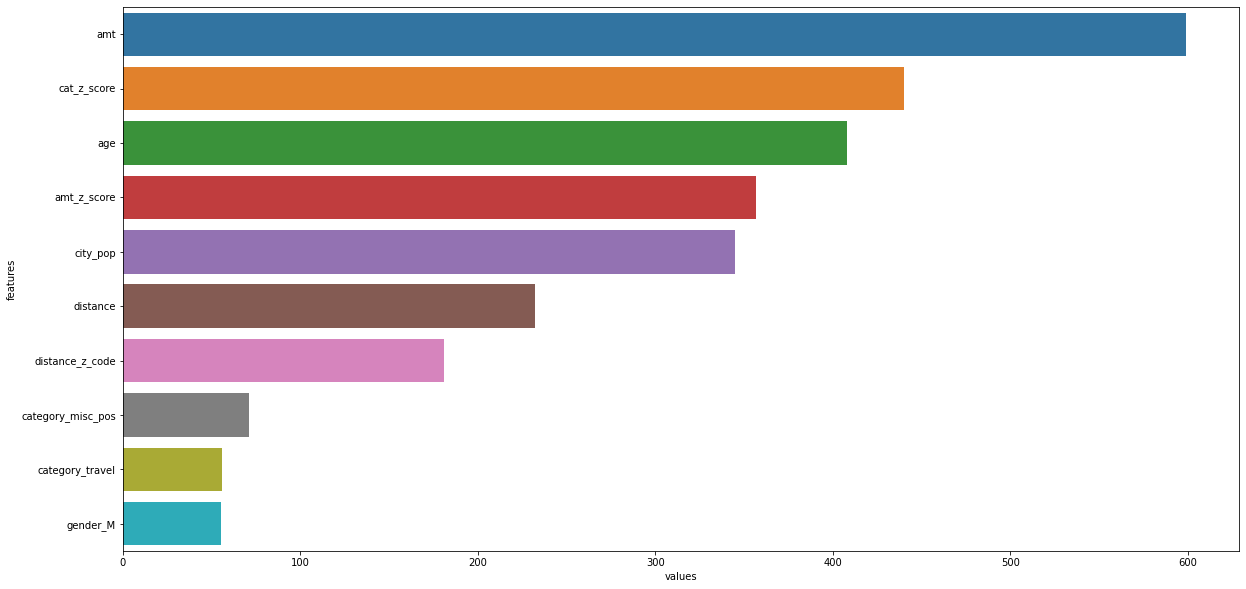

In [136]:
feature_imp = pd.DataFrame({'features': X_train.columns, 'values': model.feature_importances_})
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data=feature_imp.sort_values(by='values', ascending=False).head(10))
plt.show() # 평균대비 얼마를 쓰느지 등등 상위 10개를 정리함